In [2]:
!pip install 'kaggle-environments>=0.1.6'

In [3]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from kaggle_environments import evaluate, make, utils

# Define Gym Class

In [4]:
import random

def combined_agent(default_agent, alternate_agent, epsilon):
    def updated_agent(obs, config):
        if (random.random() < epsilon):
            return alternate_agent(obs, config)
        return default_agent(obs,config)
    return updated_agent

from kaggle_environments.envs.connectx.connectx import negamax_agent
from kaggle_environments.envs.connectx.connectx import random_agent

e_greedy_negamax = combined_agent(negamax_agent, random_agent, 0.6)

In [5]:
class ConnectX(gym.Env):
    def __init__(self, opp= 'random',switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.env.agents['e_greedy_negamax'] = e_greedy_negamax
        self.pair = [None, 'e_greedy_negamax']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns
                * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        me_ind = self.pair.index(None) + 1
        return self.trainer.step(action),me_ind

    def update_agent(self, TrainNet,epsilon):
#     ns = {}
#     agent_str = create_agent(TrainNet)
        def my_agent(observation, configuration):
            return TrainNet.get_action(observation, epsilon)
    
#     exec(agent_str, globals(), ns)
        self.env.agents['selftrain'] = my_agent
        rand_val = random.random()
        if (rand_val < 0.05):
            self.pair = [None, 'negamax']
        elif rand_val < 0.25:
            self.pair = [None, 'random']
        else:
            self.pair = [None, 'selftrain']
        self.trainer = self.env.train(self.pair)
    
    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()

    def render(self, **kwargs):
        return self.env.render(**kwargs)

# Define Model

In [6]:
class DeepModel(nn.Module):
    def __init__(
        self,
        num_states,
        num_actions,
        ):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(1,20,(1,1))
        self.conv2 = nn.Conv2d(1,20,(1,7))
        self.conv3 = nn.Conv2d(1,20,(6,1))
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(20*55,128)
        self.output_layer = nn.Linear(128, num_actions)

    def forward(self, x):
        x = x.view(-1,1,6,7)
        self.input_x = x
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x))
        x3 = self.relu(self.conv3(x))
        x1 = x1.view(-1,20,42)
        x2 = x2.view(-1,20,6)
        x3 = x3.view(-1,20,7)
        x_cat = torch.cat((x1,x2,x3),2)
        x = x_cat.view(-1,20*55)
        x = self.relu(self.fc(x))
        x = self.output_layer(x)
        return x


class DQN:
    def __init__(
        self,
        num_states,
        num_actions,
        gamma,
        max_experiences,
        min_experiences,
        batch_size,
        lr,
        ):
        self.device = torch.device(('cuda'
                                    if torch.cuda.is_available() else 'cpu'
                                   ))
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.model = DeepModel(num_states,
                               num_actions).to(self.device)
        self.model_target = DeepModel(num_states, num_actions).to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss().to(self.device)
        self.experience = {
            's': [],
            'a': [],
            'r': [],
            's2': [],
            'done': [],
            }
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.param_update_count = 0
        self.target_update_freq = target_update_freq

    def predict(self, inputs, model):
        return model(torch.from_numpy(inputs).float().to(self.device))

    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            # only start training process if enough experiences in buffer
            return 0

        # randomly select n experiences in buffer to form batch
        ids = np.random.randint(low=0, high=len(self.experience['s']),
                                size=self.batch_size)
        states = np.asarray([self.preprocess(self.experience['s'][i])
                            for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        actions = torch.autograd.Variable(torch.from_numpy(actions)).type(torch.LongTensor).to(self.device)
        rewards = np.asarray([self.experience['r'][i] for i in ids])
        rewards = torch.autograd.Variable(torch.from_numpy(rewards)).type(torch.FloatTensor).to(self.device)
        # prepare labels
        states_next = np.asarray([self.preprocess(self.experience['s2'][i]) for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        dones_mask = torch.autograd.Variable(torch.from_numpy(dones)).type(torch.FloatTensor).to(self.device)
        
        # get Q values for best actions in observation
        q_values = self.predict(states_next, self.model).detach()
        _, a_prime = q_values.max(1)
        
        # get Q values from target network for next state and choise action
        q_target_values = self.predict(states_next, self.model_target).detach()
        q_target_a_prime = q_target_values.gather(1, a_prime.unsqueeze(1))
        q_target_a_prime = q_target_a_prime.squeeze()
        
        # if current state is end of episode, no next Q value
        q_target_a_prime = (1 - dones_mask) * q_target_a_prime
        
        # get q values of current observation
        q_vals = self.predict(states, self.model)
        q_actions = q_vals.gather(1, actions.unsqueeze(1))
        q_actions = q_actions.squeeze()
        
        # compute bellman error
        error = rewards + self.gamma * q_target_a_prime - q_actions
        
        clipped_error = -1.0 * error.clamp(-1,1)
        
        self.optimizer.zero_grad()
        q_actions.backward(clipped_error.data)
        
        self.optimizer.step()
        
        self.param_update_count += 1
        
        if self.param_update_count % self.target_update_freq == 0:
                self.model_target.load_state_dict(self.model.state_dict())

    def get_action(self, state, epsilon):
        # to get an action by using epsilon-greedy
        if np.random.random() < epsilon:
            return int(np.random.choice([c for c in range(self.num_actions) if state['board'][c] == 0]))
        else:
            prediction = \
                self.predict(np.atleast_2d(self.preprocess(state)), self.model)[0].detach().cpu().numpy()
            for i in range(self.num_actions):
                if state['board'][i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))

    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for (key, value) in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        self.model.load_state_dict(TrainNet.model.state_dict())

    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path))

    def preprocess(self, state):
        # each state consists of overview of the board and the mark in the obsevations
        # results = (state['board'])[:]
        # results.append(state.mark)
        # return results
        board = (state['board'])[:]
        if state.mark == 1:
            board[board == 2] = -1
        else:
            board[board == 1] = -1
            board[board == 2] = 1
        return board

    def backward_hook(self, module, grad_in, grad_out):
        print(grad_out[0].shape)

In [7]:
def check_row_trio(track,my_pos):
    if my_pos == 1:
        opp_pos = 2
    else:
        opp_pos = 1
    def check_inner(x):
        pre_def = [(x,x,x,0),(x,x,0,x),(x,0,x,x),(0,x,x,x)]
        pcount = 0
        for row in pre_def:
            if row in track.keys():
                pcount += 1
        return pcount
    return check_inner(my_pos), check_inner(opp_pos)

def check_row_duo(track,my_pos):
    if my_pos == 1:
        opp_pos = 2
    else:
        opp_pos = 1
    def check_inner(x):
        pre_def = [(x,x,0,0),(x,0,x,0),(x,0,0,x),(0,x,x,0),(0,x,0,x),(0,0,x,x)]
        pcount = 0
        for row in pre_def:
            if row in track.keys():
                pcount += 1
        return pcount
    return check_inner(my_pos), check_inner(opp_pos)

def play_game(
    env,
    TrainNet,
    TargetNet,
    epsilon,
    copy_step,
    ):
    rewards = 0
    iter = 0
    done = False
    
#     if n % 100 == 0 and n >= 0:
#         env.update_agent(TrainNet,epsilon)
    observations = env.reset()
    while not done:
        action = TrainNet.get_action(observations, epsilon)
        prev_observations = observations
        (observations, reward, done, info),me_ind = env.step(action)
        rs_board = np.array(observations['board']).reshape(6,7)
        track = defaultdict(int)
        for row in rs_board:
            for ind in range(0,len(row) - 3):
                track[tuple(row[ind:ind+4])] += 1
        for col in np.transpose(rs_board):
            for ind in range(0,len(col) - 3):
                track[tuple(row[ind:ind+4])] += 1
        me_win_nr,opp_win_nr = check_row_trio(track,me_ind)
        me_2,opp_2= check_row_duo(track,me_ind)
        
        if done:
            if reward == 1:
                reward = 20
            elif reward == 0:
                reward = -20
            else:
                reward = 10
        else:
            reward = 0.2
            reward += 5 * me_win_nr
            reward -= 5 * opp_win_nr
            reward += 2 * me_2
            reward -= 2 * opp_2
        rewards += reward

        exp = {
            's': prev_observations,
            'a': action,
            'r': reward,
            's2': observations,
            'done': done,
            }
        
        TrainNet.add_experience(exp)
        TrainNet.train(TargetNet)
        
        iter += 1
        if iter % copy_step == 0:
            TargetNet.copy_weights(TrainNet)
    return rewards

# Training

In [8]:
gamma = 0.99
copy_step = 25
max_experiences = 10000
min_experiences = 100
batch_size = 128
lr = 1e-2
epsilon = 0.9
decay = 0.999
min_epsilon = 0.1
episodes = 10000
target_update_freq = 2000

precision = 7

In [9]:
from collections import Counter,defaultdict


env = ConnectX()

num_states = env.observation_space.n
num_actions = env.action_space.n

all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes) # Last 100 steps
all_epsilons = np.empty(episodes)

# Initialize models
TrainNet = DQN(num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr)
# TrainNet.load_weights('weights-double-q-conv.pth')
# TargetNet.load_weights('weights-double-q-conv.pth')

In [9]:
from tqdm.notebook import tqdm

for n in tqdm(range(episodes)):
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    all_total_rewards[n] = total_reward
    avg_reward = all_total_rewards[max(0, n - 100):(n + 1)].mean()
    all_avg_rewards[n] = avg_reward
    all_epsilons[n] = epsilon
    
    if n % 500 == 0:
        print('[{}/{}] episode_reward: {:.3f}, avg_reward: {:.3f}, epsilon: {:.5f}'.format(n,episodes,total_reward, avg_reward, epsilon))
        TrainNet.save_weights('./weights-double-q-conv.pth')

[0/10000] episode_reward: 16.000, avg_reward: 16.000, epsilon: 0.89910
[500/10000] episode_reward: -5.200, avg_reward: 17.570, epsilon: 0.54520
[1000/10000] episode_reward: 75.600, avg_reward: 25.214, epsilon: 0.33059
[1500/10000] episode_reward: 49.000, avg_reward: 24.584, epsilon: 0.20047
[2000/10000] episode_reward: 38.600, avg_reward: 34.107, epsilon: 0.12156
[2500/10000] episode_reward: 21.000, avg_reward: 32.448, epsilon: 0.10000
[3000/10000] episode_reward: 31.800, avg_reward: 37.250, epsilon: 0.10000
[3500/10000] episode_reward: 6.000, avg_reward: 39.176, epsilon: 0.10000
[4000/10000] episode_reward: 134.600, avg_reward: 41.299, epsilon: 0.10000
[4500/10000] episode_reward: 36.200, avg_reward: 37.723, epsilon: 0.10000
[5500/10000] episode_reward: 39.400, avg_reward: 36.663, epsilon: 0.10000
[6000/10000] episode_reward: 21.600, avg_reward: 43.139, epsilon: 0.10000
[6500/10000] episode_reward: 67.800, avg_reward: 40.073, epsilon: 0.10000
[7000/10000] episode_reward: 43.600, avg_r

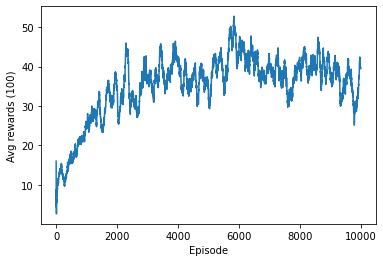

In [10]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

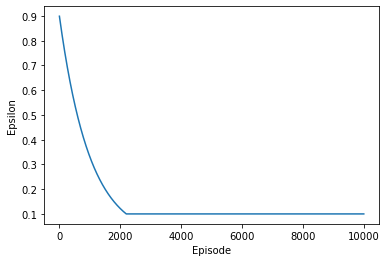

In [11]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [12]:
TrainNet.save_weights('./weights-double-q-conv.pth')

# Create Agent

In [10]:
def my_agent(observation, configuration):
    return TrainNet.get_action(observation, 0)

In [12]:
def mean_reward(rewards):
    return np.round(rewards.count([1,-1])/len(rewards),2)

from nega_agents import return_nega
negamax_agent1 = return_nega(1)
negamax_agent2 = return_nega(2)
negamax_agent3 = return_nega(3)

print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=100)))
print("My Agent vs. Negamax1 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent1], num_episodes=100)))
print("My Agent vs. Negamax2 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent2], num_episodes=100)))
print("My Agent vs. Negamax3 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent3], num_episodes=100)))
print("My Agent vs. Negamax4 Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=100)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=100)))
print("Negamax1 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent1, my_agent], num_episodes=100)))
print("Negamax2 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent2, my_agent], num_episodes=100)))
print("Negamax3 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent3, my_agent], num_episodes=100)))
print("Negamax4 Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=100)))

My Agent vs. Random Agent: 0.85
My Agent vs. Negamax1 Agent: 0.64
My Agent vs. Negamax2 Agent: 0.29
My Agent vs. Negamax3 Agent: 0.46
My Agent vs. Negamax4 Agent: 0.07
Random Agent vs. My Agent: 0.31
Negamax1 Agent vs. My Agent: 0.32
Negamax2 Agent vs. My Agent: 0.78
Negamax3 Agent vs. My Agent: 0.56
Negamax4 Agent vs. My Agent: 0.91
